### Modélisation 

### Prédiction de l'émission du CO2 : 

In [1]:
# Import des librairies
import pandas as pd 
import numpy as np
import math
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
# Pour les warnings
import warnings
warnings.filterwarnings('ignore')
# Pour les algorithmes du machine learning
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from pandas import MultiIndex, Int16Dtype
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

In [2]:
#Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le 
#plus d'informations
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format',lambda x: "%.6f" % x)

In [3]:
df_energie_5 = pd.read_csv(os.getcwd()+"/CSV/df_energie_5.csv")

In [4]:
df_energie_5.head()

,TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,BuildingType,Neighborhood,PrimaryPropertyType,BuildingAge,SteamUse,Electricity,NaturalGas,ENERGYSTARScore
0,249.980000,1.000000,12,88434,0,HOTEL,88434.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,89,1,1,1,60.000000
1,295.860000,1.000000,11,103566,15064,HOTEL,83880.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,20,0,1,1,61.000000
2,2089.280000,1.000000,41,956110,196718,HOTEL,756493.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,47,1,1,1,43.000000
3,286.430000,1.000000,10,61320,0,HOTEL,61320.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,90,1,1,1,56.000000
4,505.010000,1.000000,18,175580,62000,HOTEL,123445.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,36,0,1,1,75.000000


Preprocessor : 

In [5]:
# Variables numériques
numeric_features = ['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','BuildingAge',
                    'LargestPropertyUseTypeGFA','SteamUse','Electricity','NaturalGas']
# Utilisation du Standarscaler() pour normalisation des données dans la pipeline

numeric_transformer = Pipeline(
                    steps=[("scaler", StandardScaler())]
                    )
# Variables catégorielles

categorical_features = ['BuildingType','LargestPropertyUseType','PrimaryPropertyType','Neighborhood']

# Utilisation du OneHotencoder pour l'encodage des variables catégorielles

categorical_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

#Définition des étapes du preprocessing

preprocessor = ColumnTransformer(
                transformers=[
                ("numeric", numeric_transformer, numeric_features),
                ("categ", categorical_transformer, categorical_features)]
                )

In [6]:
from sklearn import set_config
set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFATotal', 'PropertyGFAParking',
                                  'BuildingAge', 'LargestPropertyUseTypeGFA',
                                  'SteamUse', 'Electricity', 'NaturalGas']),
                                ('categ',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['BuildingType', 'LargestPropertyUseType',
                                  'PrimaryPropertyType', 'Neighborhood'])])

- Dataset avec seulement les lignes où energystarscore est rempli

In [7]:
print(df_energie_5.shape[0],"lignes avant suppression")
index_to_drop=df_energie_5[df_energie_5['ENERGYSTARScore'].isnull()].index
df_energie_5.drop(index_to_drop, inplace=True)
print(df_energie_5.shape[0],"lignes après suppression")

1639 lignes avant suppression
1079 lignes après suppression


- Séparation du jeu de données en jeu d'entrainement et de test : 
- Séparation : 80% entrainement, 20% test

In [8]:
# Les features
X = df_energie_5.drop(['TotalGHGEmissions','ENERGYSTARScore'], axis=1)
# Les targets
Y = df_energie_5[['TotalGHGEmissions']]
# Division du dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y , train_size=0.8, random_state=42)
print("shape of original dataset :", df_energie_5.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (1079, 15)
shape of input - training set (863, 13)
shape of output - training set (863, 1)
shape of input - testing set (216, 13)
shape of output - testing set (216, 1)


- Tester le Dummy Regressor en tant que Baseline

In [9]:
# Je définie les paramètres
param_dr = {
             "regressor__strategy": ["mean"]}

dr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=DummyRegressor(), 
                                transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal")

                                ),
                            param_grid=param_dr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = None))])

In [10]:
dr_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                                                   'PrimaryPropertyType',
                                                   'Neighborhood'])])),
                ('grid_search_lr',
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(regressor=DummyRegressor(),
                                                                   transformer=QuantileTransformer(n_quantiles=500,
                                                                                                   output_distribution='normal')),
                              param_grid={'regressor__strategy': ['mean']},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

In [11]:
dr_grid_cv.fit(X_train,y_train)
errors = abs(np.mean(y_train) - y_test)
print(f"base_MAE = {round(np.mean(errors),3)}")

base_MAE = TotalGHGEmissions   263.450000
dtype: float64


- Tester différents modèles : 
- Régression linéaire

In [12]:
# Je définie les paramètres
param_lr = {"regressor__fit_intercept": [True, False]
             }

lr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lr', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor = LinearRegression(), 
                            transformer = QuantileTransformer(n_quantiles=900, output_distribution="normal")   
                                ),
                            param_grid=param_lr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = None))]
                        )

In [13]:
lr_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                                                   'Neighborhood'])])),
                ('grid_search_lr',
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(regressor=LinearRegression(),
                                                                   transformer=QuantileTransformer(n_quantiles=900,
                                                                                                   output_distribution='normal')),
                              param_grid={'regressor__fit_intercept': [True,
                                                                       False]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- Ridge : 

In [14]:
param_ridge= {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.arange(0.0, 1.1, 0.1),
              "regressor__solver" : ["auto"],
              "regressor__tol": [0.0001],
              "regressor__fit_intercept": [True, False]
             }
ridge_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_ridge', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor=Ridge(),
                            transformer=QuantileTransformer(n_quantiles=600,output_distribution="normal")
  
                              
                            ),
                            param_grid=param_ridge,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [15]:
ridge_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                                                                                                   output_distribution='normal')),
                              n_jobs=-1,
                              param_grid={'regressor__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'regressor__fit_intercept': [True,
                                                                       False],
                                          'regressor__max_iter': [10, 100,
                                                                  1000],
                                          'regressor__solver': ['auto'],
                                          'regressor__tol': [0.0001]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- Lasso

In [16]:
param_lasso= {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.arange(0.0, 1.1, 0.1),
              "regressor__fit_intercept": [True, False],
              
              

             }
lasso_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lasso', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor=Lasso(),
                            transformer=QuantileTransformer(n_quantiles=300,output_distribution="normal")

                           
                            ),
                            param_grid=param_lasso,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = None))])

In [17]:
lasso_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                              estimator=TransformedTargetRegressor(regressor=Lasso(),
                                                                   transformer=QuantileTransformer(n_quantiles=300,
                                                                                                   output_distribution='normal')),
                              param_grid={'regressor__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'regressor__fit_intercept': [True,
                                                                       False],
                                          'regressor__max_iter': [10, 100,
                                                                  1000]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- Elastic net

In [18]:
param_enet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.arange(0.0, 1.1, 0.1),
              "regressor__l1_ratio": 10**np.linspace(10,-2,100)*0.5,
              "regressor__tol": [1.860e+01]
             }
enet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor=ElasticNet(),
                                
                             transformer=QuantileTransformer(n_quantiles=600, output_distribution="normal")

                            ),
                            param_grid=param_enet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = None))])


In [19]:
enet_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
                                          'regressor__max_iter': [10, 100,
                                                                  1000],
                                          'regressor__tol': [18.6]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- Modèles non linéaires : 

- Random Forest regressor

In [20]:
param_rf = {'regressor__max_features' : ['auto', 'sqrt'],
             'regressor__max_depth': [5,10,20,50],
            'regressor__min_samples_split': [2, 5,10],
            'regressor__bootstrap' : [True, False],
            'regressor__min_samples_leaf': [1,2,5,10]
           }

rf_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                        TransformedTargetRegressor(
                        regressor=RandomForestRegressor(), 
                        func=np.log, 
                        inverse_func=np.exp),
                        param_grid=param_rf,
                        cv=5,
                        scoring=('r2','neg_mean_absolute_error'),
                        refit='neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs = None))])

In [21]:
rf_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor()),
                              param_grid={'regressor__bootstrap': [True, False],
                                          'regressor__max_depth': [5, 10, 20,
                                                                   50],
                                          'regressor__max_features': ['auto',
                                                                      'sqrt'],
                                          'regressor__min_samples_leaf': [1, 2,
                                                                          5,
                                                                          10],
                                          'regressor__min_samples_split': [2, 5,
                                                                           10]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- Gradient Boosting

In [22]:
# Hyperparamères

param_grb = {'regressor__learning_rate': [0.02,0.03,0.1,0.5],
             'regressor__subsample': [0.9, 0.5, 0.2, 0.1,1],
             'regressor__max_depth'    : [2,3,5, 6, 7,8,9],
             'regressor__n_estimators' : [25,50,100]
             }

grb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_grb', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor=GradientBoostingRegressor(),
                            func=np.log1p, 
                            inverse_func=np.expm1
                            
                            ),
                            param_grid=param_grb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = None))])

In [23]:
grb_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                              estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=GradientBoostingRegressor()),
                              param_grid={'regressor__learning_rate': [0.02,
                                                                       0.03,
                                                                       0.1,
                                                                       0.5],
                                          'regressor__max_depth': [2, 3, 5, 6,
                                                                   7, 8, 9],
                                          'regressor__n_estimators': [25, 50,
                                                                      100],
                                          'regressor__subsample': [0.9, 0.5,
                                                                   0.2, 0.1,
                                                                   1]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

- XGBoost

In [24]:
param_xgb = {'regressor__learning_rate': [0.05, 0.10, 0.15],
             'regressor__gamma': [0.5, 1, 1.5, 2, 5],
             'regressor__max_depth' : [3, 4, 5, 6, 8],
             'regressor__min_child_weight' : [1, 5, 10] ,
             'regressor__colsample_bytree' : [0.6, 0.8, 1.0],
             'regressor__n_estimators': [10, 50,100]
             }

       
xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', GridSearchCV(
                            TransformedTargetRegressor(
                            regressor=XGBRegressor(),
                            func=np.log1p, 
                            inverse_func=np.expm1
                          
                            ),
                            param_grid=param_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = None))])

In [25]:
param_xgb

{'regressor__learning_rate': [0.05, 0.1, 0.15],
 'regressor__gamma': [0.5, 1, 1.5, 2, 5],
 'regressor__max_depth': [3, 4, 5, 6, 8],
 'regressor__min_child_weight': [1, 5, 10],
 'regressor__colsample_bytree': [0.6, 0.8, 1.0],
 'regressor__n_estimators': [10, 50, 100]}

In [26]:
xgb_grid_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'BuildingAge',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SteamUse', 'Electricity',
                                                   'NaturalGas']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Buildi...
                                                                                          verbosity=None)),
                              param_grid={'regressor__colsample_bytree': [0.6,
                                                                          0.8,
                                                                          1.0],
                                          'regressor__gamma': [0.5, 1, 1.5, 2,
                                                               5],
                                          'regressor__learning_rate': [0.05,
                                                                       0.1,
                                                                       0.15],
                                          'regressor__max_depth': [3, 4, 5, 6,
                                                                   8],
                                          'regressor__min_child_weight': [1, 5,
                                                                          10],
                                          'regressor__n_estimators': [10, 50,
                                                                      100]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

In [30]:
algos={
   'LinearRegression' :lr_grid_cv,
   'Ridge' : ridge_grid_cv,
   'Lasso' : lasso_grid_cv,
   'Elastic': enet_grid_cv,
   'RandomforestRegressor' : rf_grid_cv,
   'Gradientboosting' : grb_grid_cv,
   'Xgbregressor':xgb_grid_cv,
 


}
def test(algos):

    results = []
    for algo_name,algo in algos.items():
    
        algo.fit(X_train, y_train)
       
    
        mae=round(mean_absolute_error(y_test, algo.predict(X_test)) ,3)
        rmse=round(np.sqrt(mean_squared_error(y_test, algo.predict(X_test))),3)
        r2_train=round(r2_score(y_train,algo.predict(X_train) ),3)
        r2_test=round(r2_score(y_test,algo.predict(X_test) ),3)
        results.append([algo_name,mae,rmse,r2_train,r2_test])
        global df
        df = pd.DataFrame( results, columns = ['Models', 'MAE','RMSE','R2_train','R2_test'] )
    
    return df

In [31]:
test(algos)

,Models,MAE,RMSE,R2_train,R2_test
0,LinearRegression,184.396000,891.933000,-0.325000,0.298000
1,Ridge,187.186000,914.277000,-0.448000,0.262000
2,Lasso,211.872000,963.391000,0.077000,0.180000
3,Elastic,223.594000,1052.760000,0.012000,0.021000
4,RandomforestRegressor,121.715000,491.118000,1.000000,0.787000
5,Gradientboosting,104.762000,386.209000,0.966000,0.868000
6,Xgbregressor,114.229000,432.294000,0.932000,0.835000


- Evaluer le modèle : 

In [42]:
grb_grid_cv.named_steps['grid_search_grb'].best_params_

{'regressor__learning_rate': 0.5,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 100,
 'regressor__subsample': 1}

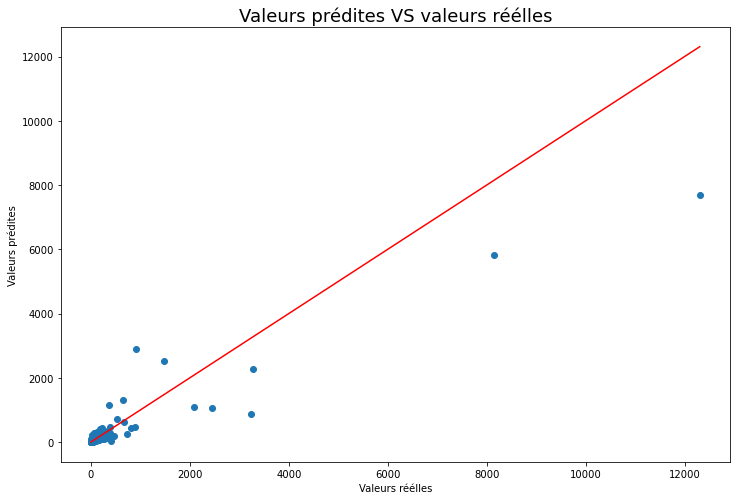

In [43]:
pred_co2 = grb_grid_cv.predict(X_test)

fig=plt.figure(figsize=(12,8))

plt.scatter(y_test, pred_co2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color="red")
plt.xlabel("Valeurs réélles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs prédites VS valeurs réélles", fontsize=18)
plt.show()

### Evaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions CO2

- EPA a calculé une note de 1 à 100 qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale

In [35]:
numerical_features = df_energie_5.select_dtypes(include=['int64','float64'])

ENERGYSTARScore = numerical_features['ENERGYSTARScore']

In [36]:
#Je rajoute la variable
X['ENERGYSTARScore'] = ENERGYSTARScore
#je la rajoute dans les variables numériques de la pipeline
numeric_features.append('ENERGYSTARScore')

In [37]:
# Je refais la division
X_train, X_test, y_train, y_test = train_test_split(X, Y , train_size=0.8, random_state=42)

print("shape of original dataset :", df_energie_5.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (1079, 15)
shape of input - training set (863, 14)
shape of output - training set (863, 1)
shape of input - testing set (216, 14)
shape of output - testing set (216, 1)


In [39]:
X

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,BuildingType,Neighborhood,PrimaryPropertyType,BuildingAge,SteamUse,Electricity,NaturalGas,ENERGYSTARScore
0,1.000000,12,88434,0,HOTEL,88434.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,89,1,1,1,60.000000
1,1.000000,11,103566,15064,HOTEL,83880.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,20,0,1,1,61.000000
2,1.000000,41,956110,196718,HOTEL,756493.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,47,1,1,1,43.000000
3,1.000000,10,61320,0,HOTEL,61320.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,90,1,1,1,56.000000
4,1.000000,18,175580,62000,HOTEL,123445.000000,NONRESIDENTIAL,DOWNTOWN,HOTEL,36,0,1,1,75.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,1.000000,2,24990,0,OFFICE,24990.000000,NONRESIDENTIAL,GREATER DUWAMISH,SMALL- AND MID-SIZED OFFICE,87,0,1,1,9.000000
1621,1.000000,3,45000,0,K-12 SCHOOL,45728.000000,NONRESIDENTIAL,GREATER DUWAMISH,K-12 SCHOOL,1,0,1,0,77.000000
1629,1.000000,1,13661,0,OFFICE,13661.000000,NONRESIDENTIAL COS,MAGNOLIA / QUEEN ANNE,OFFICE,64,0,1,0,75.000000
1632,1.000000,1,15398,0,OFFICE,15398.000000,NONRESIDENTIAL COS,SOUTHEAST,OFFICE,56,0,1,1,93.000000


- Tester les différents algorithmes les plus performants

In [40]:
algos={
  
   
   'Gradientboosting' : grb_grid_cv,
   'Xgbregressor':xgb_grid_cv,
   'RandomforestRegressor' : rf_grid_cv,
   


}
def test(algos):

    results = []
    for algo_name,algo in algos.items():
    
        algo.fit(X_train, y_train)
       
    
        mae=round(mean_absolute_error(y_test, algo.predict(X_test)) ,3)
        rmse=round(np.sqrt(mean_squared_error(y_test, algo.predict(X_test))),3)
        r2_train=round(r2_score(y_train,algo.predict(X_train) ),3)
        r2_test=round(r2_score(y_test,algo.predict(X_test) ),3)
        results.append([algo_name,mae,rmse,r2_train,r2_test])
        global df_ess
        df_ess = pd.DataFrame( results, columns = ['Models', 'MAE','RMSE','R2_train','R2_test']).sort_values(by="R2_test",ascending=False)
    
    return df_ess

In [41]:
test(algos)

,Models,MAE,RMSE,R2_train,R2_test
1,Xgbregressor,103.339000,381.733000,0.962000,0.871000
0,Gradientboosting,124.351000,451.097000,0.994000,0.820000
2,RandomforestRegressor,134.682000,649.528000,0.824000,0.627000


In [44]:
xgb_grid_cv.named_steps['grid_search_xgb'].best_params_

{'regressor__colsample_bytree': 0.6,
 'regressor__gamma': 0.5,
 'regressor__learning_rate': 0.15,
 'regressor__max_depth': 4,
 'regressor__min_child_weight': 1,
 'regressor__n_estimators': 100}

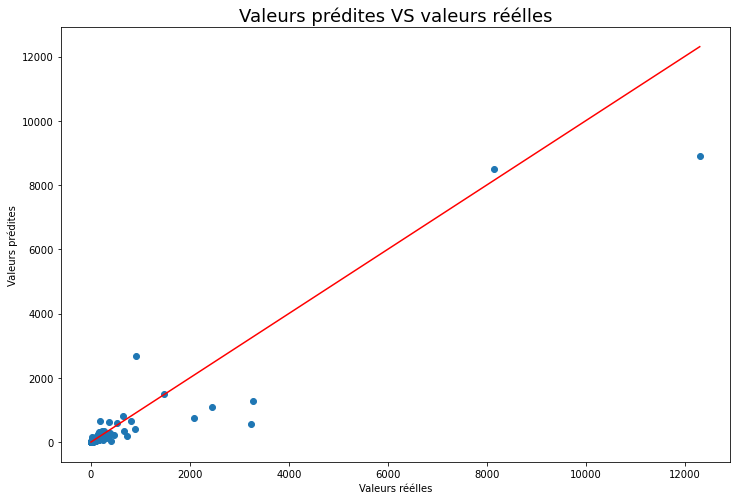

In [45]:
pred_co2_energy = xgb_grid_cv.predict(X_test)

fig=plt.figure(figsize=(12,8))

plt.scatter(y_test, pred_co2_energy)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color="red")
plt.xlabel("Valeurs réélles")
plt.ylabel("Valeurs prédites")
plt.title("Valeurs prédites VS valeurs réélles", fontsize=18)
plt.show()

- Features importance

SHAP signifie SHapley Additive exPlanations. C'est un moyen de calculer l'impact d'une caractéristique sur la valeur de la variable cible. L'idée est que vous devez considérer chaque fonctionnalité comme un acteur et l'ensemble de données comme une équipe. Chaque joueur donne sa contribution au résultat de l'équipe. La somme de ces contributions nous donne la valeur de la variable cible étant donné certaines valeurs des caractéristiques (c'est-à-dire étant donné un enregistrement particulier).


In [46]:
import shap

print("SHAP Version : {}".format(shap.__version__))

SHAP Version : 0.41.0


In [47]:
#mlp_grid_cv.best_estimator_
xgb_grid_cv.feature_names_in_

array(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'BuildingType', 'Neighborhood',
       'PrimaryPropertyType', 'BuildingAge', 'SteamUse', 'Electricity',
       'NaturalGas', 'ENERGYSTARScore'], dtype=object)

Tout d'abord, nous devons créer un objet appelé explainer. C'est l'objet qui prend en entrée la méthode de prédiction de notre modèle et le jeu de données d'apprentissage. Afin de rendre SHAP indépendant du modèle, il effectue une perturbation autour des points de l'ensemble de données d'apprentissage et calcule l'impact de cette perturbation sur le modèle. C'est un type de technique de rééchantillonnage, dont le nombre d'échantillons est défini ultérieurement. Cette approche est liée à une autre approche célèbre appelée LIME, qui s'est avérée être un cas particulier de l'approche SHAP originale. Le résultat est une estimation statistique des valeurs SHAP.

In [48]:
f = lambda x: xgb_grid_cv.predict(
    pd.DataFrame(x, columns=X_train.columns)
)

explainer = shap.KernelExplainer(f, X_train)

Using 863 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Nous pouvons maintenant calculer les valeurs de forme. Ils sont calculés en rééchantillonnant l'ensemble de données d'apprentissage et en calculant l'impact sur ces perturbations, nous devons donc définir un nombre approprié d'échantillons. Pour cet exemple, je vais utiliser 100 échantillons.

Ensuite, l'impact est calculé sur le jeu de données de test.

In [49]:
shap_values = explainer.shap_values(X_test,nsamples=100)

  0%|          | 0/216 [00:00<?, ?it/s]

À la fin, nous obtenons un tableau numpy (n_samples,n_features). Chaque élément est la valeur de forme de cette caractéristique de cet enregistrement. N'oubliez pas que les valeurs de forme sont calculées pour chaque entité et pour chaque enregistrement.

Nous pouvons maintenant tracer ce que l'on appelle un "summary plot". Commençons par le tracer, puis nous commenterons les résultats.


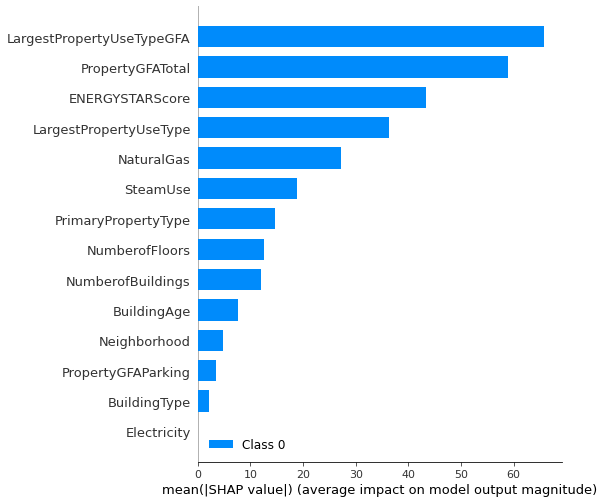

In [50]:
shap.summary_plot(shap_values,X_test)

Ci-dessus, nous avons généré un graphique récapitulatif avec un type de graphique sous forme de barre basé sur les valeurs de forme générées à partir des données de test à l'aide du premier explicateur linéaire. Le graphique à barres montre l'impact moyen de chaque fonctionnalité sur la prédiction finale. Cela met également en évidence l'importance des fonctionnalités en fonction des valeurs de forme.

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0]  ,X_test,xgb_grid_cv.feature_names_in_)